In [1]:
library('ggplot2')
library("dplyr")
library("qvalue")
library("limma")
library('ggbeeswarm')

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggbeeswarm’ was built under R version 3.6.3”

In [2]:
#limma with linear models and empyrical Bayes. 
eb.fit <- function(dat, design){
  n <- dim(dat)[1]
  fit <- lmFit(dat[6:length(dat)], design)
  fit.eb <- eBayes(fit)
  #geometric mean fold change
  logFC <- fit.eb$coefficients[, 2]
  #p value
  p.val <- fit.eb$p.value[, 2]
  #q value (multiple hypothesis testing correction)
  q.val <- qvalue(p.val)$q
  results.eb <- data.frame(logFC, p.val,  q.val, dat[1], dat[2], dat[3],dat[4],dat[5])
  results.eb <- results.eb[order(results.eb$p.val), ]
  return(results.eb)
}

In [3]:
#copy numbers functions
Avogadro<-6.022140857 * 10^23
copyNumber<- function(histone_intensity, intensity, mw){
  dna_mass_histone_mass=(6.75*10^-12)/histone_intensity
  #copy numbers
  copy_number=round((intensity)*((Avogadro)/mw)*(dna_mass_histone_mass),0)
  return(copy_number)
}

In [4]:
# histone protein IDS
histones<-c('O60814;Q99879;Q99877;Q93079;Q5QNW6;P62807;P58876;P57053;Q5QNW6-2;Q99880;Q96A08','O75367;O75367-3;O75367-2',
            'P06899;Q16778;P33778;P23527;Q6DRA6;Q6DN03','P07305;P07305-2','P10412',
            'P16104;Q96QV6;Q9BTM1-2;REV__Q8NB25-4;REV__Q8NB25-2;REV__Q8NB25-3;REV__Q8NB25;Q71UI9-5','P16401','P16402',
            'P16403','P22492','P62805','P68431;Q16695;Q6NXT2;P0DPK2;P0DPK5','P84243','Q8IUE6','Q8N257','Q9P0M6','Q71DI3',
            'Q02539','Q93077;Q7L7L0;P04908;Q99878;Q96KK5;Q9BTM1;Q16777;Q6FI13;P20671;P0C0S8', 'Q92522',
            'Q71UI9;P0C0S5;Q71UI9-3;Q71UI9-4;Q71UI9-2')

In [5]:
#read the text file and filter out contaminants, reverse and only identified by site
input<-read.delim("~/Documents/data/hipsci/hesc_ipsc/new_txt/proteinGroups.txt", header=TRUE, sep="\t")
input<-input[input$Only.identified.by.site!="+",]
input<-input[input$Reverse!="+",]
input<-input[input$Potential.contaminant!="+",]
input<- input[order(input$Protein.IDs),] 

In [6]:
reporters_temp<-select(input, contains('Protein.IDs'), contains('Mol..weight..kDa.'), contains('Reporter.intensity'),-contains('corrected'), -contains('count'))


In [8]:
# assign MS1 of the histones based on the ratio of reporter intensities
histones_ratios<-as.data.frame(apply(reporters_temp[reporters_temp$Protein.IDs %in% histones,]
                                           [4:13], 1, function(x) x/(sum(x,na.rm = TRUE))))
perc_intensity<-function(ratios, intensity){
  return(ratios*intensity)
}
histones_intensity<-colSums(as.data.frame(t(mapply(perc_intensity,histones_ratios,
                                                   input[input$Protein.IDs %in% histones,]$Intensity))),na.rm = TRUE)

In [9]:
#convert molecular weight into kDA
mw<-input$Mol..weight..kDa.*1000
#function to calculate all copy numbers
copiesAll<- function(histone_intensity, temp){
  copyCalc<-function(histone_intensity, protein_intensity, mw){
    copies<-copyNumber(histone_intensity, protein_intensity, mw)
  }
  res<-unlist(mapply(copyCalc, histone_intensity, temp, mw))
}
# assign MS1 intensity based on the ratio of reporter intensities
all_ratios<-as.data.frame(apply(reporters_temp[4:13],1, function(x) x/(sum(x,na.rm = TRUE))))
all_intensity<-as.data.frame(t(mapply(perc_intensity,all_ratios, input$Intensity)))

In [17]:
#calculate copy numbers
all_copies<-as.data.frame(mapply(copiesAll, histones_intensity, all_intensity))
#add proteins identifiers
all_copies$Protein.IDs<-input$Protein.IDs
#rename the columns in the data frame
colnames(all_copies) <- c('Copies.1.ipsc', 'Copies.1.hesc','Copies.2.ipsc', 
                          'Copies.2.hesc', 'Copies.3.ipsc','Copies.3.hesc',
                          'Copies.4.ipsc','Copies.4.hesc','empty.1', 'empty.2', 'Protein.IDs')
all_copies$mean_copies_ipsc<-unlist(apply(all_copies[,c('Copies.1.ipsc','Copies.2.ipsc',
                                                        'Copies.3.ipsc','Copies.4.ipsc')],1, function(x) mean(x[x>0], na.rm = TRUE)))
all_copies$mean_copies_hesc<-unlist(apply(all_copies[,c('Copies.1.hesc','Copies.2.hesc',
                                                        'Copies.3.hesc','Copies.4.hesc')],1, function(x) mean(x[x>0], na.rm = TRUE)))


In [18]:
# add the descriptive and QC elements to the dataframe
all_copies$Gene.name<-input$Gene.names
all_copies$sequence_coverage<-input$Sequence.coverage....
all_copies$unique_razor_peptides<-input$Razor...unique.peptides
all_copies$unique_peptides<-input$Unique.peptides
all_copies$peptides<-input$Peptides
all_copies$mw<-input$Mol..weight..kDa.

In [19]:
#check that the sum of histone copy numbers are between 245-315 million copies
colSums(all_copies[all_copies$Protein.IDs %in% histones,][1:8], na.rm = TRUE)

Copies.1.ipsc Copies.1.hesc Copies.2.ipsc Copies.2.hesc Copies.3.ipsc 
    303290544     291853889     301725301     291441387     303916592 
Copies.3.hesc Copies.4.ipsc Copies.4.hesc 
    284481709     304297688     293121898

In [20]:
# export the copy numbers file
write.table(all_copies, file = "~/Documents/data/hipsci/hesc_ipsc/hesc_ipsc_copy_numbers.csv", sep = ",",row.names=FALSE)

In [21]:
#differential expression analysis
options <-  c(1,2)
#specify the model: in this case 4 reps of each conditions
ipsc_factor <- model.matrix(~factor(rep(options, c(4,4))))
#create a new dataframe, first 5 elements are descriptive and only used for the output
data=all_copies[c('Protein.IDs','Gene.name', 'unique_razor_peptides', 'mean_copies_ipsc', 'mean_copies_hesc',
                  'Copies.1.ipsc', 'Copies.2.ipsc','Copies.3.ipsc', 'Copies.4.ipsc',
                  'Copies.1.hesc', 'Copies.2.hesc', 'Copies.3.hesc', 'Copies.4.hesc' )]
#log 2 convert the data before using limma
data[6:13]<-log2(data[6:13])
#run through limma
res <- eb.fit(data, ipsc_factor)

Warning message:
“Partial NA coefficients for 3 probe(s)”

Warning message:
“Removed 2 rows containing missing values (geom_point).”

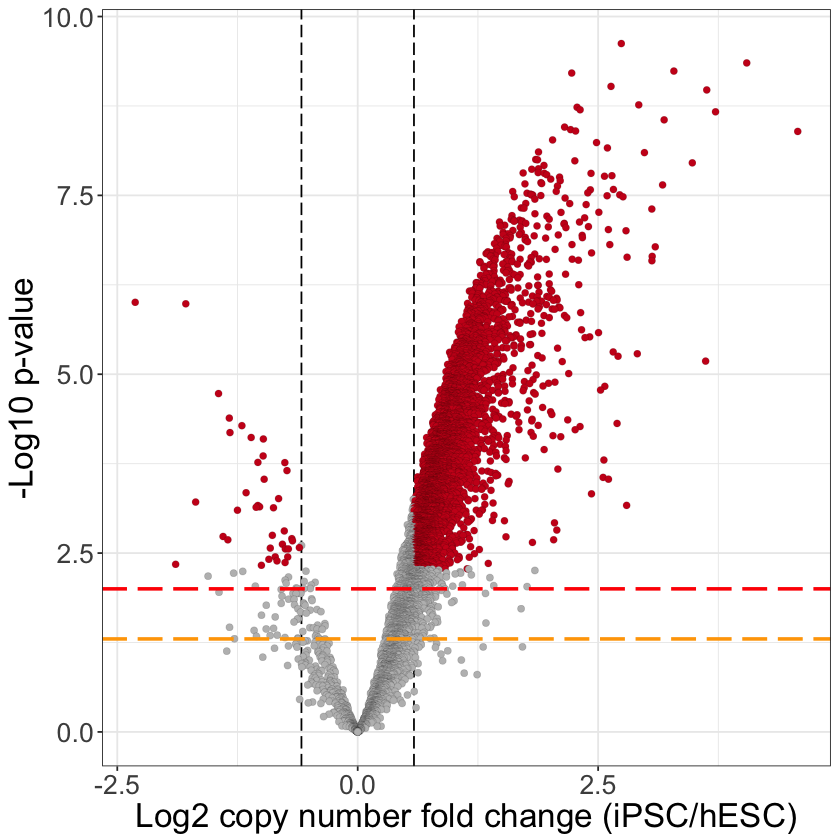

In [22]:
#highlight proteins where q-value<0.01 and fold change is greater or smaller than 1.5 fold
res$highlight<-''
res[(res$q.val<=0.001) & (!is.na(res$logFC)) & (res$logFC<=-0.585),]$highlight<-'yes'
res[(res$q.val<=0.001) & (!is.na(res$logFC)) & (res$logFC>=0.585),]$highlight<-'yes'
ggplot(data=res[res$unique_razor_peptides>=2,], aes(x=logFC*-1, y=-log10(p.val), fill=highlight))+ theme_bw()+
  #geom_hline(yintercept=0) +  geom_vline(xintercept=0.613,linetype="longdash") +
  xlab('Log2 copy number fold change (iPSC/hESC)') +ylab('-Log10 p-value')+
  geom_vline(xintercept=0.585,linetype="longdash")+
  geom_vline(xintercept=-0.585,linetype="longdash")+
  scale_fill_manual(values = c("#bdbdbd", "#cb181d"))+
  geom_point( colour="black" , size = 2,stroke = 0.05, shape=21)+
  geom_hline(yintercept=1.3, linetype="longdash", colour='orange', size=1)+
  geom_hline(yintercept=2, linetype="longdash", colour='red', size=1)+
  guides(fill=FALSE)+
  theme(text = element_text(size=20))


	Welch Two Sample t-test

data:  total_copies_xist$total_copies[1:4] and total_copies_xist$total_copies[5:8]
t = 4.9398, df = 5.2759, p-value = 0.00373
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  43.35407 134.43549
sample estimates:
mean of x mean of y 
 237.6374  148.7427 


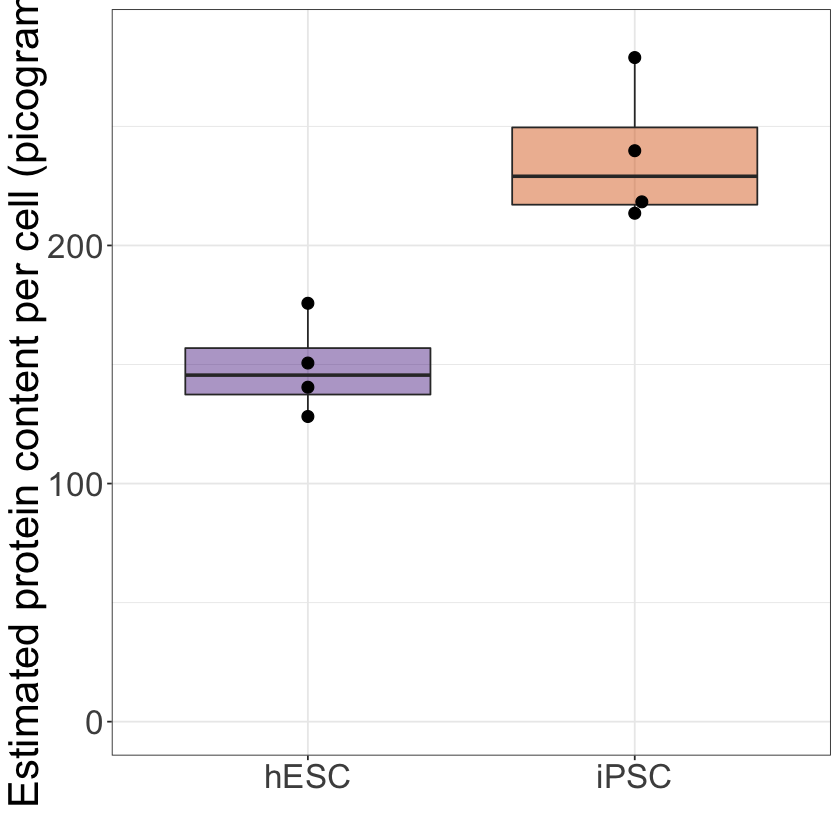

In [26]:
#protein content calculation: convert from kDa to picograms and sum
ipsc<-colSums( all_copies[,c('Copies.1.ipsc', 'Copies.2.ipsc','Copies.3.ipsc', 'Copies.4.ipsc')]
              *all_copies$mw*1.66054e-9, na.rm = TRUE)
#protein content calculation: convert from kDa to picograms and sum
hesc<-colSums( all_copies[,c(  'Copies.1.hesc', 'Copies.2.hesc', 'Copies.3.hesc', 'Copies.4.hesc')]*all_copies$mw*1.66054e-9, na.rm = TRUE)
label<-rep(c('iPSC', 'hESC'), c(4,4))
total_copies_xist<-data.frame(total_copies=c(ipsc, hesc), category=label)
total_copies_xist$description<-'All copies'
#t test to compare protein content
t.test(total_copies_xist$total_copies[1:4], total_copies_xist$total_copies[5:8])


ggplot(total_copies_xist, aes(x=category, y=total_copies, fill=as.factor(label))) + 
  #stat_summary(fun.data = mean_se, geom = "bar", position = "dodge")+
  geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=1, notch=FALSE, alpha=.45) + 
  geom_beeswarm(dodge.width=.8,cex=2, size=3)+
  labs(x="", y = "Estimated protein content per cell (picograms)") +
  scale_fill_manual(values = c('#54278F', '#D95F02'))+
  ylim(c(0,285))+
  theme_bw()+
  theme( text = element_text(size=25))+guides(fill=FALSE)


	Welch Two Sample t-test

data:  log10(ipsc) and log10(hesc)
t = 7.0183, df = 5.7432, p-value = 0.0005053
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2341298 0.4890090
sample estimates:
mean of x mean of y 
 4.194099  3.832530 


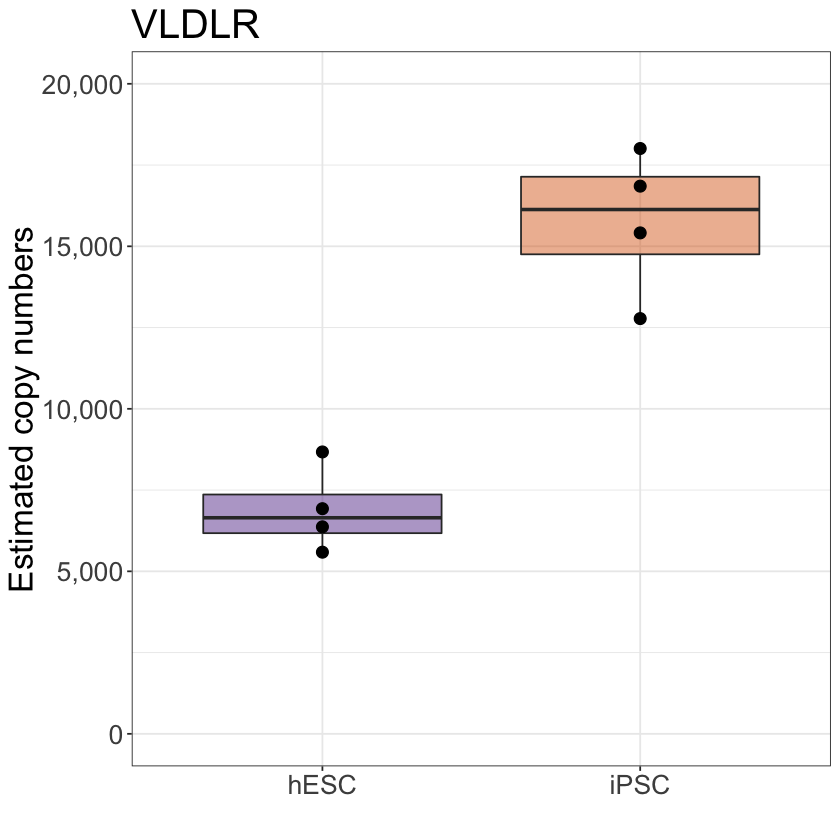

In [27]:
# specific proteins boxplot
#specify the protein id. Can be one or many (say all H1 histones)
prots<-c('P98155-2;P98155')
#specify the gene name
genes<-'VLDLR'
ipsc<-colSums( all_copies[all_copies$Protein.IDs %in% prots,]
               [,c('Copies.1.ipsc', 'Copies.2.ipsc','Copies.3.ipsc', 'Copies.4.ipsc')], na.rm=TRUE)
hesc<-colSums( all_copies[all_copies$Protein.IDs %in% prots,]
               [,c(  'Copies.1.hesc', 'Copies.2.hesc', 'Copies.3.hesc', 'Copies.4.hesc')], na.rm = TRUE)
label<-rep(c('iPSC', 'hESC'), c(4,4))
total_copies_xist<-data.frame(total_copies=c(ipsc, hesc), category=label)
total_copies_xist$description<-'All copies'
#used in case its a protein family, otherwise the p-value used is derived from limma
t.test(log10(ipsc), log10(hesc))

ggplot(total_copies_xist, aes(x=category, y=total_copies, fill=as.factor(label))) + 
  #stat_summary(fun.data = mean_se, geom = "bar", position = "dodge")+
  geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=1, notch=FALSE, alpha=.45) + 
  geom_beeswarm(dodge.width=.8,cex=2, size=3)+
  labs(x="", y = "Estimated copy numbers", title=genes) +
  scale_color_manual(values = c('#54278F', '#D95F02'))+
  scale_fill_manual(values = c('#54278F', '#D95F02'))+
  #modify the scale
  scale_y_continuous(labels = scales::comma,limits=c(0,20000))+
  theme_bw()+
  theme( text = element_text(size=20))+guides(color=FALSE, fill=FALSE)